In [ ]:
#Pour voir d'autre matchs juste à changer le path du fichier 

import pandas as pd
import json
from mplsoccer import Pitch
import matplotlib.pyplot as plt

with open('../data/ligue1/3900513.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
dataf = pd.DataFrame(data)
df = pd.json_normalize(data)
essai = df['team.name'].unique()

print(essai)


['Troyes' 'Lille']


In [82]:
possession_time = df.groupby('team.name')['duration'].sum()

possession_total = possession_time.sum()
print(possession_total)

3029.2184921770004


In [83]:
possession_pct = round(possession_time/possession_total*100,2)

for equipe, poss in possession_pct.items():
    time = possession_time[equipe]
    minutes = int(time//60)
    secondes = int(time % 60)
    print(f'{equipe}: {poss}% avec {minutes}min {secondes}s')

Lille: 48.33% avec 24min 23s
Troyes: 51.67% avec 26min 5s


In [84]:
def stat_team(df, team_name):
    df_team = df[df['team.name'] == team_name]

    stats = {'Équipe': team_name}
    # Score équipe
    shot = df_team[df_team['type.name'] == 'Shot']

    stats['Buts'] = len(shot[shot['shot.outcome.name'] == 'Goal'])

    # Possession des équipes
    stats['Possession (%)'] = round(df_team['duration'].sum()/df['duration'].sum()*100,1)

    # Nombre de tir

    stats['Tirs totaux'] = len(shot)
    stats['Tirs cadrés'] = len(shot[shot['shot.outcome.name'].isin(['Goal', 'Saved'])])
    stats['Tirs non cadrés'] = len(shot[shot['shot.outcome.name'].isin(['Off T', 'Post', 'Wayward', 'Saved To Post'])])
    stats['Tirs contrés'] = len(shot[shot['shot.outcome.name'].isin(['Blocked'])])
    stats['xG'] = round(shot['shot.statsbomb_xg'].sum(),1)

    #Passes
    nbr_pass = df_team[df_team['type.name'] == 'Pass']

    stats['Nombre de passes'] = len(nbr_pass)

    stats['Passes réussies'] = len(nbr_pass[nbr_pass['pass.outcome.name'].isna()])
    stats['Taux passe (%)'] = round(len(nbr_pass[nbr_pass['pass.outcome.name'].isna()])/ len(nbr_pass)*100,1)

    stats['Passes longues'] = len(nbr_pass[nbr_pass['pass.length'] >= 27])
    stats['Passes courtes'] = len(nbr_pass[nbr_pass['pass.length'] < 27])


    pass_loc = nbr_pass.dropna(subset=['location'])
    stats['Passes dernier tiers'] = len(pass_loc[pass_loc['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)>90])

    stats['Passes clés'] = nbr_pass['pass.shot_assist'].notna().sum()

    #Centres
    nbr_centre = nbr_pass[nbr_pass['pass.cross'] == True]
    centre_reussi = nbr_centre[nbr_centre['pass.outcome.name'].isna()]

    stats['Centres'] = len(nbr_centre)
    stats['Centres réussis (%)'] = round(len(centre_reussi)/len(nbr_centre)*100,1) if len(nbr_centre) > 0 else 0    

    centre_loc = nbr_centre.dropna(subset=['location'])
    centre_reu_loc = centre_reussi.dropna(subset=['location'])

    stats['Centres droite'] = len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])
    stats['Centres gauche'] = len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40])
    stats['Centres réussis droite (%)'] = round(len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])/len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])*100,1) if len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])> 0 else 0
    stats['Centres réussis gauche (%)'] = round(len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40])/len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40])*100,1) if len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40]) > 0 else 0

    # Coup de pied arrêté
    nbr_corner = nbr_pass[nbr_pass['pass.type.name'] == 'Corner']
    nbr_coupfranc = nbr_pass[nbr_pass['pass.type.name'] == 'Free Kick']

    stats['Corners'] = len(nbr_corner)
    stats['Coup Franc'] = len(nbr_coupfranc) + len(shot[shot['shot.type.name'] == 'Free Kick'])

    #Hors jeu

    nbr_horsjeu = df_team[df_team['type.name'] == 'Offside']

    stats['Hors-jeu'] = len(nbr_horsjeu)

    #Fautes
    nbr_faute = df_team[df_team['type.name'] == 'Foul Committed']
    stats['Fautes commises'] = len(nbr_faute)

    if 'foul_won.penalty' in df_team.columns:
        nbr_penalty = df_team[df_team['foul_won.penalty'] == True]
        stats['Penalty'] = len(nbr_penalty)
    else:
        stats['Penalty'] = 0
    
    

    #Duels
    nbr_duel = df_team[df_team['type.name'] == 'Duel']
    nbr_duel_nettoyé = nbr_duel[nbr_duel['duel.outcome.name'].notna()]
    nbr_duelaerienper = len(nbr_duel[nbr_duel['duel.type.name'] == 'Aerial Lost'])
    nbr_duelaeriengag = len(df_team[(df_team.get('pass.aerial_won', pd.Series([False]*len(df_team))) == True) | (df_team.get('clearance.aerial_won', pd.Series([False]*len(df_team))) == True) | (df_team.get('shot.aerial_won', pd.Series([False]*len(df_team))) == True)])

    stats['Duel totaux'] = len(nbr_duel)
    stats['Duel gagnés (%)'] = round(len(nbr_duel_nettoyé[nbr_duel_nettoyé['duel.outcome.name'].isin(['Won','Success','Success In Play', 'Success Out'])])/len(nbr_duel_nettoyé)*100,1) if len(nbr_duel_nettoyé[nbr_duel_nettoyé['duel.outcome.name'].isin(['Won','Success','Success In Play', 'Success Out'])]) > 0 else 0

    stats['Duel aériens'] = nbr_duelaeriengag + nbr_duelaerienper
    stats['Duel aérien gagnés (%)'] = round(nbr_duelaeriengag/(nbr_duelaeriengag + nbr_duelaerienper)*100,1) if nbr_duelaeriengag > 0 else 0
    
    #Dribbles
    nbr_dribble = df_team[df_team['type.name'] == 'Dribble']
    nbr_dribblesucc = nbr_dribble[nbr_dribble['dribble.outcome.name'] == 'Complete']

    stats['Dribbles tentés'] = len(nbr_dribble) 
    stats['Dribbles réussis'] = len(nbr_dribblesucc)
    stats['Dribbles réussis (%)'] = round(len(nbr_dribblesucc)/len(nbr_dribble)*100,1) if len(nbr_dribblesucc) > 0 else 0

    #Actions défensives
    nbr_interception = df_team[df_team['interception.outcome.name'].isin(['Success', 'Success In Play', 'Success Out', 'Won'])]
    nbr_clear = df_team[df_team['type.name'] == 'Clearance']
   

    stats['Interceptions'] = len(nbr_interception)
    stats['Dégagement'] = len(nbr_clear)

    if 'block.deflection' in df_team.columns:
        nbr_block = df_team[df_team['block.deflection'] == True]
        stats['Bloc'] = len(nbr_block)
    else :
        stats['Bloc'] = 0
        
    #Arrêts
    nbr_save = df_team[df_team['goalkeeper.type.name'] == 'Shot Saved']

    stats['Arrêts'] = len(nbr_save)

    return stats

teams = df['team.name'].unique()
all_stats = []

for team in teams:
    stats = stat_team(df, team)
    all_stats.append(stats)

stats_df = pd.DataFrame(all_stats)

print(stats_df.T)

                                 0      1
Équipe                      Troyes  Lille
Buts                             1      1
Possession (%)                51.7   48.3
Tirs totaux                     10     16
Tirs cadrés                      4      6
Tirs non cadrés                  4      8
Tirs contrés                     2      2
xG                             0.9    1.2
Nombre de passes               506    464
Passes réussies                387    355
Taux passe (%)                76.5   76.5
Passes longues                 130    128
Passes courtes                 376    336
Passes dernier tiers            82     87
Passes clés                      7     11
Centres                         15     20
Centres réussis (%)           33.3   45.0
Centres droite                  12     15
Centres gauche                   3      5
Centres réussis droite (%)    25.0   53.3
Centres réussis gauche (%)    66.7   20.0
Corners                          6     12
Coup Franc                      25

In [85]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

equipe1 = stats_df.iloc[0]
equipe2 = stats_df.iloc[1]

categorie = ['Possession (%)', 'xG', 'Tirs totaux', 'Tirs cadrés', 'Taux passe (%)', 'Centres', 'Duel gagnés (%)', 'Fautes commises']
categorie = categorie[::-1]
fig = go.Figure()

fig.add_trace(go.Bar(y=categorie, x=[-equipe1[cat] for cat in categorie], orientation ='h', name=equipe1['Équipe'], marker_color='blue', text= [equipe1[cat] for cat in categorie],  textposition='outside'))
fig.add_trace(go.Bar(y=categorie, x=[equipe2[cat] for cat in categorie], orientation ='h', name=equipe2['Équipe'], marker_color='red', text= [equipe2[cat] for cat in categorie],  textposition='outside'))

fig.update_layout(title=f'{equipe1['Équipe']} {equipe1['Buts']} - {equipe2['Buts']} {equipe2['Équipe']}', barmode='overlay', xaxis= dict(title='', showticklabels=False, zeroline=True, zerolinewidth=2))

fig.show()

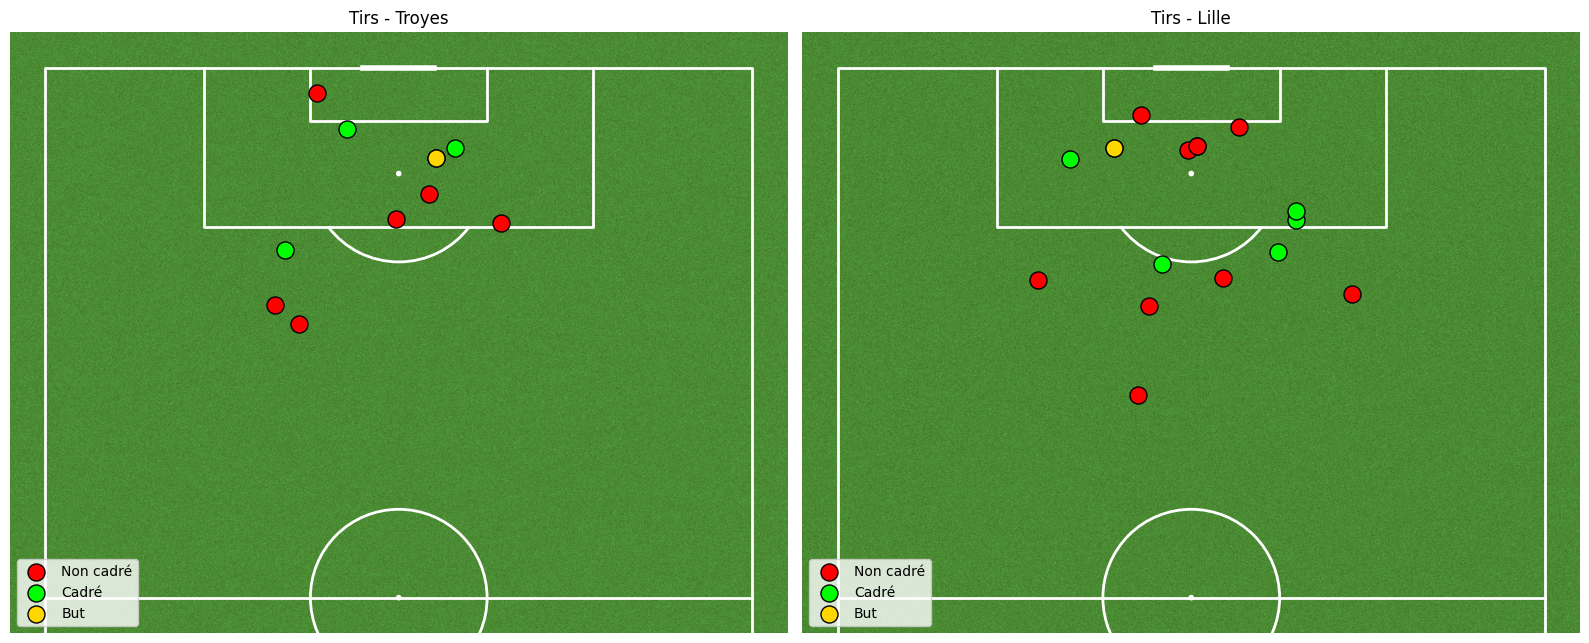

In [86]:
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt

shot = df[df['type.name'] == 'Shot'].copy()
shot['cadre'] = shot['shot.outcome.name'].isin(['Saved'])
shot['goal'] = shot['shot.outcome.name'].isin(['Goal'])

equipe1_name = df['team.name'].unique()[0]
equipe2_name = df['team.name'].unique()[1]

shot1 = shot[shot['team.name'] == equipe1_name]
shot1cadre = shot1[shot1['cadre'] == True]
shot1noncadre = shot1[shot1['cadre'] == False]
shot1goal = shot1[shot1['goal'] == True]

shot2 = shot[shot['team.name'] == equipe2_name]
shot2cadre = shot2[shot2['cadre'] == True]
shot2noncadre = shot2[shot2['cadre'] == False]
shot2goal = shot2[shot2['goal'] == True]


def getcoord(df_shot):
    x = df_shot['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    y = df_shot['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)
    return x,y

x, y = getcoord(shot1cadre)

fig, axes = plt.subplots(1,2, figsize=(16,8))

pitch1 = VerticalPitch(pitch_type='statsbomb', half=True, pitch_color='grass', line_color='white')
pitch1.draw(ax=axes[0])
x, y = getcoord(shot1noncadre)
pitch1.scatter(x, y, ax=axes[0], color='red', s=150, edgecolor='black', linewidth=1, label="Non cadré", zorder=2)
x, y = getcoord(shot1cadre)
pitch1.scatter(x, y, ax=axes[0], color='lime', s=150, edgecolor='black', linewidth=1, label="Cadré", zorder=2)
x, y = getcoord(shot1goal)
pitch1.scatter(x, y, ax=axes[0], color='gold', s=150, edgecolor='black', linewidth=1, label="But", zorder=2)

axes[0].set_title(f'Tirs - {equipe1_name}', fontsize=12)
axes[0].legend(loc='lower left')

pitch2 = VerticalPitch(pitch_type='statsbomb', half=True, pitch_color='grass', line_color='white')
pitch2.draw(ax=axes[1])
x, y = getcoord(shot2noncadre)
pitch1.scatter(x, y, ax=axes[1], color='red', s=150, edgecolor='black', linewidth=1, label="Non cadré", zorder=2)
x, y = getcoord(shot2cadre)
pitch1.scatter(x, y, ax=axes[1], color='lime', s=150, edgecolor='black', linewidth=1, label="Cadré", zorder=2)
x, y = getcoord(shot2goal)
pitch1.scatter(x, y, ax=axes[1], color='gold', s=150, edgecolor='black', linewidth=1, label="But", zorder=2)

axes[1].set_title(f'Tirs - {equipe2_name}', fontsize=12)
axes[1].legend(loc='lower left')


plt.tight_layout()
plt.show()

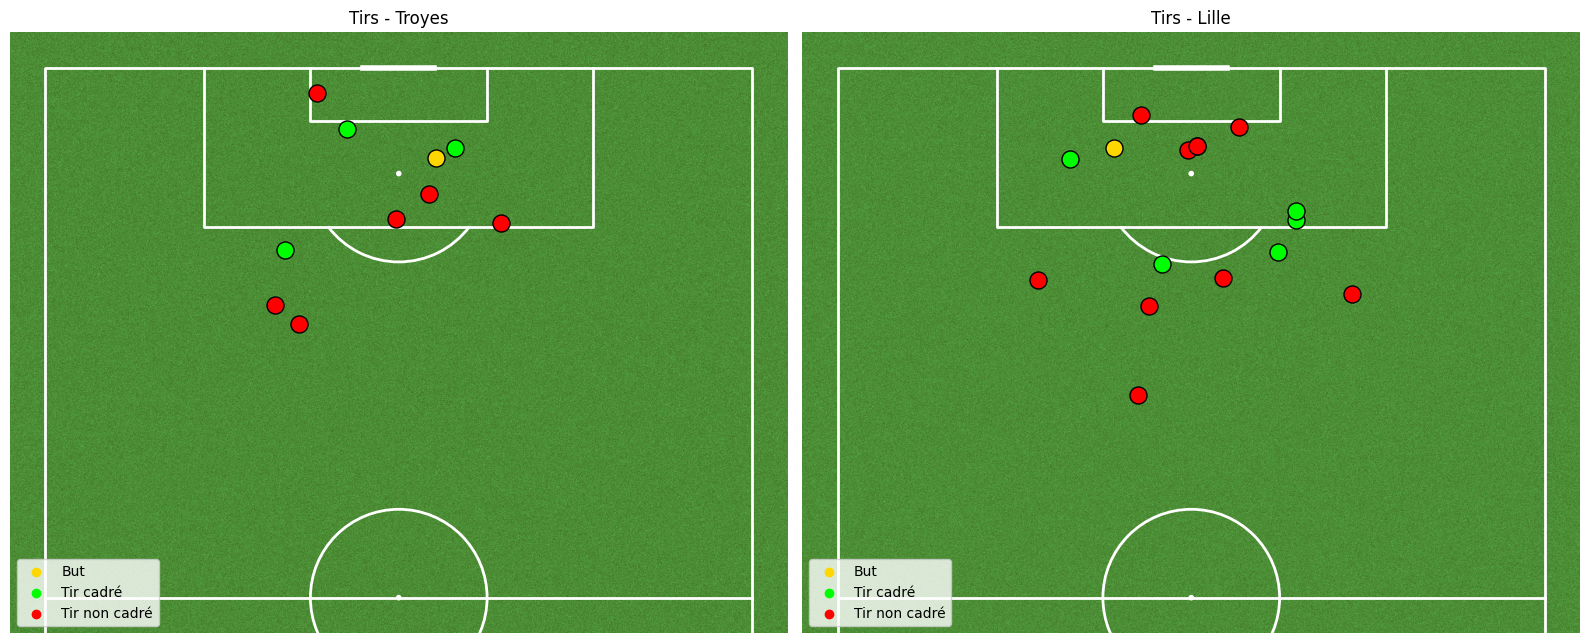

In [87]:
teams = df['team.name'].unique()

fig, axes= plt.subplots(1, 2, figsize=(16,8))

row = df[df['type.name'] == 'Shot']


for idx,team in enumerate(teams):
    pitch = VerticalPitch(half=True, pitch_type='statsbomb', pitch_color='grass', line_color='white')
    pitch.draw(ax=axes[idx])

    team_shot = row[row['team.name'] == team]

    for i, shot in team_shot.iterrows():
        outcome = shot['shot.outcome.name']
        x, y = shot['location']
        if outcome == 'Goal' :
            pitch.scatter(x,y, ax=axes[idx], color='gold', edgecolor='black', s=150, linewidth=1, zorder=2)
        elif outcome == 'Saved' : 
            pitch.scatter(x,y, ax=axes[idx], color='lime', edgecolor='black', s=150, linewidth=1, zorder=2)
        else :
            pitch.scatter(x,y, ax=axes[idx], color='red', edgecolor='black', s=150, linewidth=1, zorder=2)
    
    axes[idx].scatter([], [], color='gold', label='But')
    axes[idx].scatter([], [], color='lime', label='Tir cadré')
    axes[idx].scatter([], [], color='red', label='Tir non cadré')

    axes[idx].legend(loc='lower left')
    axes[idx].set_title(f'Tirs - {team}')
plt.tight_layout()
plt.show()


       